In [1]:
# Essentials
import time
import copy
from collections import OrderedDict
import random
import os
from tifffile import TiffFile
from PIL import Image, ImageOps
from pathlib import Path
from tqdm.notebook import tqdm
# Sklearn
from sklearn.model_selection import train_test_split
# Data
import numpy as np
import pandas as pd
# Plot
import matplotlib.pyplot as plt
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, Subset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
# Torchvision
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF

# Implementation of UNet

In [2]:
class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=10, init_features=32):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(features*16, features*8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4,kernel_size=2, stride=2)
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, name="dec1")
        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))


    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [3]:
unet = UNet()

# Dataset

In [4]:
class LandCoverData():
    """Class to represent the S2GLC Land Cover Dataset for the challenge,
    with useful metadata and statistics.
    """
    # image size of the images and label masks
    IMG_SIZE = 256
    # the images are RGB+NIR (4 channels)
    N_CHANNELS = 4
    # we have 9 classes + a 'no_data' class for pixels with no labels (absent in the dataset)
    N_CLASSES = 10
    CLASSES = [
        'no_data',
        'clouds',
        'artificial',
        'cultivated',
        'broadleaf',
        'coniferous',
        'herbaceous',
        'natural',
        'snow',
        'water'
    ]
    # classes to ignore because they are not relevant. "no_data" refers to pixels without
    # a proper class, but it is absent in the dataset; "clouds" class is not relevant, it
    # is not a proper land cover type and images and masks do not exactly match in time.
    IGNORED_CLASSES_IDX = [0, 1]

    # The training dataset contains 18491 images and masks
    # The test dataset contains 5043 images and masks
    TRAINSET_SIZE = 18491
    TESTSET_SIZE = 5043

    # for visualization of the masks: classes indices and RGB colors
    CLASSES_COLORPALETTE = {
        0: [0,0,0],
        1: [255,25,236],
        2: [215,25,28],
        3: [211,154,92],
        4: [33,115,55],
        5: [21,75,35],
        6: [118,209,93],
        7: [130,130,130],
        8: [255,255,255],
        9: [43,61,255]
        }
    CLASSES_COLORPALETTE = {c: np.asarray(color) for (c, color) in CLASSES_COLORPALETTE.items()}

    # statistics
    # the pixel class counts in the training set
    TRAIN_CLASS_COUNTS = np.array(
        [0, 20643, 60971025, 404760981, 277012377, 96473046, 333407133, 9775295, 1071, 29404605]
    )
    # the minimum and maximum value of image pixels in the training set
    TRAIN_PIXELS_MIN = 1
    TRAIN_PIXELS_MAX = 24356

In [7]:
def show_image(image, display_min=50, display_max=400, ax=None):
    """Show an image.
    Args:
        image (numpy.array[uint16]): the image. If the image is 16-bit, apply bytescaling to convert to 8-bit
    """
    if image.dtype == np.uint16:
        iscale = display_max - display_min
        scale = 255 / iscale
        byte_im = (image) * scale
        byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
        image = byte_im
    # show image
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off")
    im = ax.imshow(image)
    return im

def show_mask(mask, classes_colorpalette, classes=None, add_legend=True, ax=None):
    """Show a a semantic segmentation mask.
    Args:
       mask (numpy.array[uint8]): the mask in 8-bit
       classes_colorpalette (dict[int, tuple]): dict mapping class index to an RGB color in [0, 1]
       classes (list[str], optional): list of class labels
       add_legend
    """
    show_mask = np.empty((*mask.shape, 3))
    for c, color in classes_colorpalette.items():
        show_mask[mask == c, :] = color
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off")
    im = ax.imshow(show_mask)
    if add_legend:
        # show legend mapping pixel colors to class names
        import matplotlib.patches as mpatches
        handles = []
        for c, color in classes_colorpalette.items():
            handles.append(mpatches.Patch(color=color, label=classes[c]))
        ax.legend(handles=handles)
    return im

In [8]:
def numpy_parse_image(image_path, mask_path):
    """Load an image and its segmentation mask as numpy arrays and returning a tuple
    Args:
        image_path (bytes): path to image
    Returns:
        (numpy.array[uint16], numpy.array[uint8]): the image and mask arrays
    """
    with TiffFile(image_path) as tifi, TiffFile(mask_path) as tifm:
        image = tifi.asarray()
        mask = tifm.asarray()
        # add channel dimension to mask: (256, 256, 1)
        mask = mask[..., None]
    return image, mask

(256, 256, 4)


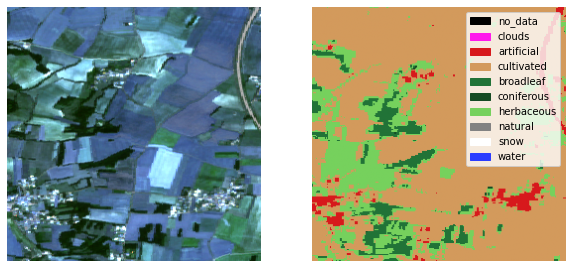

In [9]:
LCD = LandCoverData()

image_path = '/kaggle/input/dataset/dataset/train/images/1.tif'
mask_path = '/kaggle/input/dataset/dataset/train/masks/1.tif'
image, mask = numpy_parse_image(image_path, mask_path)
print(image.shape)
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
show_image(image, display_min=0, display_max=2200, ax=axs[0])
classes_colorpalette = {c: color/255. for (c, color) in LCD.CLASSES_COLORPALETTE.items()}
show_mask(mask.reshape((256,256)), classes_colorpalette = classes_colorpalette, classes=LCD.CLASSES, add_legend=True, ax=axs[1])
plt.show()

In [ ]:
msk = torch.from_numpy(mask.transpose(2,1,0).copy())

In [ ]:
random_mask = torch.from_numpy(np.random.randint(2,9,(1,256,256)))

In [ ]:
def normalize(input_image, input_mask):
    image = np.float32(input_image)/LCD.TRAIN_PIXELS_MAX
    return image, input_mask

In [ ]:
image, mask = normalize(input_image=image, input_mask=mask)

In [ ]:
def load_image_train(input_image, input_mask):
    # random 90 degree rotations on whole channels
    # random 90 degree rotations on last channel
    # random vertical/horizontal flip
    # Normalization 
    image, mask = input_image, input_mask
    if np.random.uniform(()) > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    if np.random.uniform(()) > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
    if np.random.uniform(()) > 0.5:
        image = np.rot90(image)
        mask = np.rot90(mask)
    elif np.random.uniform(()) > 0.5:
        image = np.rot90(image, 3)
        mask = np.rot90(mask, 3)

    image, mask = normalize(image, mask)
    return image, mask   

# Define custom transforms

The motivation behind redefining transforms is that we need to apply the same transform to both mask and image.

In [10]:
class ImageSegementationDataset(Dataset):

    in_channels = 4
    out_channels = 10

    def __init__(self, images_dir, mode="train", random_state=42):

        assert mode in ["train", "test"], "mode should either be 'train' or 'test'"
        
        self.mode = mode
        self.images_dir = images_dir
        self.path_indices = os.listdir(os.path.join(self.images_dir, 'images'))
        self.random_state = random_state
        
    def transform(self, image, mask=None):
        
        if self.random_state:
            random.seed(self.random_state)
            
        if isinstance(mask, np.ndarray):
            if random.random() > 0.5:
                image = np.fliplr(image)
                mask = np.fliplr(mask)
                
            if random.random() > 0.5:
                image = np.flipud(image)
                mask = np.flipud(mask)

            if random.random() > 0.5:
                image = np.rot90(image)
                mask = np.rot90(mask)
                
            elif random.random() > 0.5:
                image = np.rot90(image, 3)
                mask = np.rot90(mask, 3)
            image = np.float32(image)/LCD.TRAIN_PIXELS_MAX
            
            image = torch.from_numpy(image.transpose(2, 0, 1).copy())
            mask = torch.from_numpy(mask.transpose(2, 0, 1).copy())
            return image, mask
        else:
            # if random.random() > 0.5:
            #     image = np.fliplr(image)
            # if random.random() > 0.5:
            #     image = np.flipud(image)

            # if random.random() > 0.5:
            #     image = np.rot90(image)
            # elif random.random() > 0.5:
            #     image = np.rot90(image, 3)

            image = np.float32(image)/LCD.TRAIN_PIXELS_MAX
            image = torch.from_numpy(image.transpose(2, 0, 1).copy())
            return image
        
    @staticmethod
    def parse_tiff(path):
        """Loads a Tiff image 
        Args:
            image_path (bytes): path to image
        Returns:
            numpy.array[uint16]: the image 
        """
        with TiffFile(path) as tifi:
            image = tifi.asarray()
        return image

    def __len__(self):
        return len(self.path_indices)

    def __getitem__(self, idx):
        if self.mode == 'train':
            image_path = os.path.join(self.images_dir,'images', self.path_indices[idx])
            mask_path = os.path.join(self.images_dir,'masks', self.path_indices[idx])
            image = ImageSegementationDataset.parse_tiff(image_path)
            mask = ImageSegementationDataset.parse_tiff(mask_path)
            # add channel dimension to mask: (256, 256, 1)
            mask = np.expand_dims(mask, axis=-1)
            image, mask = self.transform(image, mask)
            return image, mask
        else:
            image_path = os.path.join(self.images_dir,'images', self.path_indices[idx])
            image = ImageSegementationDataset.parse_tiff(image_path)
            image = self.transform(image)
            return image

In [11]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

In [12]:
train_dir = 'dataset/train'
test_dir = 'dataset/test'

train_set, val_set = train_val_dataset(ImageSegementationDataset(train_dir), val_split=0.2)
test_set = ImageSegementationDataset(test_dir, mode='test')

print("Train set contains", len(train_set), "elements")
print("Validation set contains", len(val_set), "elements")
print("Test set contains", len(test_set), "elements")

Train set contains 14792 elements
Validation set contains 3699 elements
Test set contains 5043 elements


In [13]:
batch_size = 16
epochs= 10
lr= 0.001

loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(val_set, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(test_set, batch_size=batch_size, shuffle=True)

data_sizes = {"train": len(loader_train), "valid": len(loader_valid)}
print(data_sizes)

{'train': 925, 'valid': 232}


In [14]:
# Adam optimizer
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)

In [15]:
# Class_weight
weights = np.zeros((LCD.N_CLASSES,))
num_ign_classes = len(LCD.IGNORED_CLASSES_IDX)
weights[num_ign_classes:] = (1 / LCD.TRAIN_CLASS_COUNTS[2:])* LCD.TRAIN_CLASS_COUNTS[2:].sum() / (LCD.N_CLASSES-2)
weights[LCD.IGNORED_CLASSES_IDX] = 0.

class_weights = torch.FloatTensor(weights)

# Criterion
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [16]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size(), "Both vectors must have the same shape"
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

# IoU Metric

In [17]:
def mIOU(label, pred, num_classes=10):
    iou_list = list()
    present_iou_list = list()

    pred = pred.view(-1)
    label = label.view(-1)
    # Note: Following for loop goes from 0 to (num_classes-1)
    # and ignore_index is num_classes, thus ignore_index is
    # not considered in computation of IoU.
    for sem_class in range(num_classes):
        pred_inds = (pred == sem_class)
        target_inds = (label == sem_class)
        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')
        else: 
            intersection_now = (pred_inds[target_inds]).long().sum().item()
            union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
        iou_list.append(iou_now)
    return np.mean(present_iou_list)

In [18]:
def class_weight():
    weights = np.zeros((LCD.N_CLASSES,))
    num_ign_classes = len(LCD.IGNORED_CLASSES_IDX)
    weights[num_ign_classes:] = (1 / LCD.TRAIN_CLASS_COUNTS[2:])* LCD.TRAIN_CLASS_COUNTS[2:].sum() / (LCD.N_CLASSES-2)
    weights[LCD.IGNORED_CLASSES_IDX] = 0.

    class_weights = torch.FloatTensor(weights)
    return class_weights

In [19]:
def epsilon_kl_divergence(y_true, y_pred):
    
    y_true, y_pred = y_true.cpu(), y_pred.cpu()

    y_true, y_pred = np.asarray(y_true, dtype=np.float64), np.asarray(y_pred, dtype=np.float64)

    # Normalize to sum to 1 if it's not already
    y_true /= y_true.sum(1, keepdims=True)
    y_pred /= y_pred.sum(1, keepdims=True)
    # add a small constant for smoothness around 0
    y_true += 1e-7
    y_pred += 1e-7
    score = np.mean(np.sum(y_true * np.log(y_true / y_pred), 1))
    try:
        assert np.isfinite(score)
    except AssertionError as e:
        raise ValueError('score is NaN or infinite') from e
    return score

In [20]:
def training(model, train_loader, valid_loader, data_sizes, epochs, optimizer, scheduler, title):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device", device)
    model.to(device)
    
    since = time.time()

    training_loss = []
    validation_loss = []
    num_workers = 1

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loaders = {"train": train_loader, "valid": valid_loader}
    print(data_sizes)
    step = 0

    # criterion = DiceLoss()
    class_weights = class_weight().to(device)
    criterion = nn.CrossEntropyLoss(class_weights)

    for epoch in range(1, epochs+1):
        print(f'Epoch {epoch}/{epochs}')
        print('-' * 10)

        for phase in ["train", "valid"]:
            if phase == "train":
                model.eval()
            else:
                model.eval()

            running_loss = 0.0
            running_iou = 0
            running_kl_div = 0

            for image, mask in tqdm(loaders[phase]):
                image = image.to(device)
                mask = mask.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):

                    output = model(image)
                    # print(output)
                    _, preds = torch.max(output, 1)

                    loss = criterion(output, torch.tensor(mask, dtype=torch.long, device=device).squeeze())
                    # loss = criterion(output, mask)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                # running_corrects += torch.sum(iou_pytorch(output, mask))
                running_iou += mIOU(mask, preds)
                running_kl_div += epsilon_kl_divergence(mask, preds)

            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss/data_sizes[phase]
            epoch_iou = running_iou/data_sizes[phase]
            epoch_kl = running_kl_div/data_sizes[phase]
            if phase == 'train':
                training_loss.append(epoch_loss)
            else:
                validation_loss.append(epoch_loss)

            print('{} Loss: {:.4f} IoU: {:.4f} KL_div: {:.4f}'.format(phase, epoch_loss, epoch_iou, epoch_kl))
            
            if phase == 'valid' and epoch_iou > best_acc:
                best_acc = epoch_iou
                best_model = copy.deepcopy(model.state_dict())

            
    # Plotting the validation loss and training loss
    print('validation loss: ' + str(validation_loss))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model)

    # plot the training and validation loss
    plt.figure()
    plt.plot(training_loss, 'b', label='Training Loss')
    plt.plot(validation_loss, 'r', label='Validation Loss')
    plt.title(title)
    plt.legend()
    plt.show() #Change title for every model

    return model

In [24]:
def train_model(data_dir, model, epochs):
    
    class_weights = torch.FloatTensor(weights)

    # Optimizing all parameters
    optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#     optimizer_ft = optim.Adam(model.parameters(), lr = 0.001)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    # Training the model
    title = 'Variations of the training and validation loss'
    model_ft = training(model, loader_train, loader_valid, data_sizes, epochs, optimizer_ft, exp_lr_scheduler, title)

    return model_ft

In [ ]:
train_model('dataset/train', unet, epochs=10)

# Pre-trained Model

In [ ]:
import segmentation_models_pytorch as smp

unet_pre_trained = smp.Unet(encoder_name='resnet18',in_channels=4, classes=10, activation='softmax')

In [ ]:
trained_unet = train_model('dataset/train', unet_pre_trained, epochs=10)

In [ ]:
unet_pre_trained_bis = smp.Unet(encoder_name='vgg11',in_channels=4, classes=10, activation='softmax')

In [ ]:
trained_unet_bis = train_model('dataset/train', unet_pre_trained_bis, epochs=10)

# Saving the model

In [ ]:
torch.save(model_ft.state_dict(),"unet.pt")

# Loading the model

In [ ]:
def loading_saved_model(model_name):
    """Loads the saved model"""
    model = unet
    model.load_state_dict(torch.load(model_name, map_location = device))
    model.eval()
    return model

model_loaded = loading_saved_model("unet.pt")

# Prediction of the model

In [ ]:
column_names = ['no_data', 'clouds', 'artificial', 'cultivated', 'broadleaf', 'coniferous', 'herbaceous', 'natural', 'snow', 'water']

ids_test = np.arange(10)

def compute_class_counts(masks, n_classes):

    dist = np.zeros((masks.size(0), n_classes))

    for i, mask in enumerate(masks):
        arr = mask.numpy()
        count = np.bincount(arr.ravel(), minlength=n_classes)
        count[0], count[1] = 0, 0
        dist[i] = count/np.sum(count)
    return dist

def getting_pixel_distribution(model, test_loader, test_size):

    indx_test = np.arange(10087,10087+test_size, dtype=np.int32).reshape(-1,1)
    all_dist = np.zeros((test_size, LCD.N_CLASSES))

    for counter, images in enumerate(tqdm(test_loader)):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        distributions = compute_class_counts(preds, LCD.N_CLASSES)
        all_dist[counter*images.size(0):(counter+1)*images.size(0)] = distributions

    df = pd.DataFrame(all_dist, columns=column_names)
    df.insert(0, 'Sample_id', range(10087, 10087 + len(df)))

    return df

In [ ]:
test_dir = 'dataset/test'
test_set = ImageSegementationDataset(test_dir, mode='test')
test_loader = DataLoader(test_set, batch_size=batch_size)
test_size = len(test_set)

df = getting_pixel_distribution(model_loaded, test_loader, test_size)

In [ ]:
def create_from_pandas_csv(df):
    df.to_csv(r'results.csv', index = False)

create_from_pandas_csv(df)